# Qual é o melhor plano?

Você trabalha como analista para a empresa de telecomunicações Megaline. A empresa oferece aos seus cliente planos pré-pagos, Surf e Ultimate. O departamento comercial quer saber quais dos planos dão mais receita para ajustar o orçamento de publicidade.

Você vai realizar uma primeira análise dos planos baseados em uma pequena seleção de clientes. Você terá dados de 500 clientes da Megaline: que clientes são, de onde eles são, qual plano usam, o número de chamadas que eles fizeram e mensagens que eles enviaram em 2018. O seu trabalho é analisar o comportamento dos clientes e determinar quais planos pré-pagos dão mais receita.

## Inicialização

In [1]:
# Carregando todas as bibliotecas
import pandas as pd
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt
from math import factorial
import random
from scipy.stats import norm
from scipy.stats import binom,norm


## Carregar dados

In [2]:
# Carregue os arquivos de dados em diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar os dados



* Vou explorar os dados

## Planos

In [3]:
# Imprima as informações gerais/resumidas sobre o DataFrame dos planos
display(df_plans.info())
df_plans.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


In [4]:
df_plans.duplicated().sum()

0

In [5]:
# Imprimir uma amostra de dados para os planos

df_plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


 * Após a análise, não foi detectado nenhum tipo de erro para a correção, nem qualquer tipo de anomalia, como valor ausente ou duplicado.

## Corrigir dados

- Não é necesssário

## Enriqueça os dados

* Adicionei uma coluna de meses caso necessário a consulta irá facilitar.
* Alterei o tipo de dado para int na coluna renomeada e transformada de mb para gb

In [6]:
df_plans = df_plans.rename(columns={
    'mb_per_month_included': 'gb_per_month_included'})

In [7]:
df_plans['gb_per_month_included'] = df_plans['gb_per_month_included'] / 1024
df_plans['gb_per_month_included']= df_plans['gb_per_month_included'].astype('int')
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Usuários

In [8]:
# Imprima as informações gerais/resumidas sobre o DataFrame dos usuários
print(df_users.info())
df_users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


In [9]:
df_users.duplicated().sum()

0

In [10]:
# Imprimir uma amostra de dados para usuários

df_users.head(15)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN




* Dados ausentes em churn_date, porém são dados que estavam ativos quando o data frame foi coletado.
* Mudança no dtype de reg_date já que são feitos inteiramente por um único tipo de data.

### Corrigir dados



* Para não deixar dados ausentes irei substituir-los por 'active'. E o tipo de dados das datas.

In [11]:

df_users['churn_date'] = df_users['churn_date'].fillna('active')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y/%m/%d')

display(df_users.head(20))
df_users.info()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,active
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,active
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,active
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,active
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,active
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,active
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,active
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,active
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,active


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


### Enriquecer Dados

* Adicionei uma coluna de meses caso necessário a consulta irá facilitar.

In [12]:
df_users['month'] = df_users['reg_date'].dt.month
df_users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,active,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,active,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,active,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,active,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,active,5
...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,active,9
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,active,2
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,active,12
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,active,2


## Chamadas

In [13]:
# Imprima as informações gerais/resumidas sobre o DataFrame das chamadas
display(df_calls.info())
df_calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


None

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [14]:
# Imprimir uma amostra de dados para chamadas
df_calls

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37




* call_date com tipo de dado errado
* Preferi deixar as chamadas com 0.0 minutos

### Corrigir dados

In [15]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y/%m/%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer dados

* Adicionei uma coluna de meses caso necessário a consulta irá facilitar.

In [16]:

df_calls['month'] = df_calls['call_date'].dt.month
df_calls

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,11
137731,1499_200,1499,2018-10-20,10.89,10
137732,1499_201,1499,2018-09-21,8.12,9
137733,1499_202,1499,2018-10-10,0.37,10


## Mensagens

In [17]:
# Imprima as informações gerais/resumidas sobre o DataFrame das mensagens
display(df_messages.info())
df_messages.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


None

,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


In [18]:
# Imprima uma amostra dos dados para as mensagens

df_messages

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24




* É preciso mudar tipo de dado.

### Corrigir dados

* Correção do tipo de dado.

In [19]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'] , format='%Y/%m/%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer dados

* Adicionei uma coluna de meses caso necessário a consulta irá facilitar.

In [20]:
df_messages['month'] = df_messages['message_date'].dt.month
df_messages

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


## Internet

In [21]:
# Imprime as informações gerais/resumidas sobre o DataFrame da Internet
display(df_internet.info())
df_internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


None

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [22]:
# Imprime uma amostra de dados para o tráfego da Internet
df_internet

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00




* É preciso mudar o tipo de dado.

### Corrigir dados

* Correção do tipo de dado


In [23]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'] , format='%Y/%m/%d')


### Enriquecer dados

* Adicionei uma coluna de meses caso necessário a consulta irá facilitar.

In [24]:
df_internet['month'] = df_internet['session_date'].dt.month
df_internet

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


## Condições do plano de estudos

In [25]:
# Imprime as condições do plano e certifique-se de que estão claras para você
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Dados agregados por usuário



In [26]:
# Calcule o número de chamadas feitas por cada usuário por mês. Salve o resultado.
df_cm = df_calls.pivot_table(index = ['user_id', 'month'],
                                 values = 'id',
                                 aggfunc = 'count').reset_index()
df_cm


,user_id,month,id
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [27]:
# Calcule a quantidade de minutos gastos por cada usuário por mês. Salve o resultado.
df_um= df_calls.pivot_table(index=['user_id','month'],
                          values = 'duration',
                          aggfunc = 'sum')

display(df_um)


duration
user_id month          
1000    12       116.83
1001    8        171.14
        9        297.69
        10       374.11
        11       404.59
...                 ...
1498    12       324.77
1499    9        330.37
        10       363.28
        11       288.56
        12       468.10

[2258 rows x 1 columns]

In [28]:
# Calcule o número de mensagens enviadas por cada usuário por mês. Salve o resultado.

df_mm = df_messages.pivot_table(index = ['user_id', 'month'],
                                 values = 'id',
                                 aggfunc = 'count').reset_index()
df_mm


,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [29]:
# Calcule o volume de tráfego de internet usado por cada usuário por mês. Salve o resultado.

df_im= df_internet.pivot_table(index=['user_id','month'],
                          values = 'mb_used',
                          aggfunc = 'sum')

display(df_im)

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

* Irei colocar os dados agregados em um DataFrame para que um registro represente o que um usuário único consumiu em um determinado mês.

In [30]:
# Junte os dados de chamadas, minutos, mensagens, internet com base em user_id e mês
dft= df_cm.merge(df_um, on =['user_id','month'])
dft= dft.merge(df_mm, on =['user_id','month'])
dft= dft.merge(df_im, on =['user_id','month'])

dft


,user_id,month,id_x,duration,id_y,mb_used
0,1000,12,16,116.83,11,1901.47
1,1001,8,27,171.14,30,6919.15
2,1001,9,49,297.69,44,13314.82
3,1001,10,65,374.11,53,22330.49
4,1001,11,64,404.59,36,18504.30
...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27
1755,1496,10,46,301.16,18,14287.36
1756,1496,11,39,291.88,13,8547.36
1757,1496,12,40,278.61,11,16438.99


In [31]:
dft= dft.rename(columns= {'id_x': 'id_call_count',
                       'duration': 'total_minutes',
                       'id_y': 'id_messages_count',
                       })

dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used
0,1000,12,16,116.83,11,1901.47
1,1001,8,27,171.14,30,6919.15
2,1001,9,49,297.69,44,13314.82
3,1001,10,65,374.11,53,22330.49
4,1001,11,64,404.59,36,18504.30
...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27
1755,1496,10,46,301.16,18,14287.36
1756,1496,11,39,291.88,13,8547.36
1757,1496,12,40,278.61,11,16438.99


In [32]:
# Adicione as informações do plano
dft= dft.merge(df_users[['user_id', 'plan']], on= 'user_id')
dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan
0,1000,12,16,116.83,11,1901.47,ultimate
1,1001,8,27,171.14,30,6919.15,surf
2,1001,9,49,297.69,44,13314.82,surf
3,1001,10,65,374.11,53,22330.49,surf
4,1001,11,64,404.59,36,18504.30,surf
...,...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27,surf
1755,1496,10,46,301.16,18,14287.36,surf
1756,1496,11,39,291.88,13,8547.36,surf
1757,1496,12,40,278.61,11,16438.99,surf


[A receita mensal para cada usuário (subtraia o limite do pacote grátis do número total de chamadas, mensagens de texto, e dados; multiplique o resultado pelos valores do plano; adicione o preço mensal dependendo do plano de chamada). N.B. Isso pode não ser tão trivial quanto apenas algumas linhas, dadas as condições do plano! Portanto, não há problema em gastar algum tempo nisso.]

In [33]:
# Calcule a receita mensal de cada usuário

def chamadas_ex (row):
    plano = row['plan']
    minutos_usados = row['total_minutes']
    
    if plano == 'surf':
        if minutos_usados > 500:
            excedente = minutos_usados - 500   
        else:
            excedente = 0 
        if plano == 'ultimate':
            if minutos_usados > 3000:
                excedente = minutos_usados - 3000    
            else:
                excedente = 0      
        return excedente 

dft['calls_+']= dft.apply(chamadas_ex,axis=1)
dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan,calls_+
0,1000,12,16,116.83,11,1901.47,ultimate,NaN
1,1001,8,27,171.14,30,6919.15,surf,0.0
2,1001,9,49,297.69,44,13314.82,surf,0.0
3,1001,10,65,374.11,53,22330.49,surf,0.0
4,1001,11,64,404.59,36,18504.30,surf,0.0
...,...,...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27,surf,0.0
1755,1496,10,46,301.16,18,14287.36,surf,0.0
1756,1496,11,39,291.88,13,8547.36,surf,0.0
1757,1496,12,40,278.61,11,16438.99,surf,0.0


In [34]:
def mensagens_ex(row):
    plano = row['plan']
    mensagens_feitas = row['id_messages_count']
    
    if plano == 'surf':
        if mensagens_feitas > 50:
            excedente = mensagens_feitas - 50  
        else:
            excedente = 0  
        if plano == 'ultimate':
            if mensagens_feitas > 1000:
                excedente = mensagens_feitas - 1000   
            else:
                excedente = 0
        return excedente 
    
dft['mensagens_+']= dft.apply(mensagens_ex,axis=1)
dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan,calls_+,mensagens_+
0,1000,12,16,116.83,11,1901.47,ultimate,NaN,NaN
1,1001,8,27,171.14,30,6919.15,surf,0.0,0.0
2,1001,9,49,297.69,44,13314.82,surf,0.0,0.0
3,1001,10,65,374.11,53,22330.49,surf,0.0,3.0
4,1001,11,64,404.59,36,18504.30,surf,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27,surf,0.0,0.0
1755,1496,10,46,301.16,18,14287.36,surf,0.0,0.0
1756,1496,11,39,291.88,13,8547.36,surf,0.0,0.0
1757,1496,12,40,278.61,11,16438.99,surf,0.0,0.0


In [35]:
def internet_ex (row):
    plano = row['plan']
    internet_usada = row['mb_used']
    
    if plano == 'surf':
        if internet_usada > 15000:
            excedente = internet_usada - 15000 
        else: 
            excedente = 0 
        if plano == 'ultimate':
            if internet_usada > 30000:
                excedente = internet_usada - 30000  
            else:
                excedente = 0  
        return excedente 
    
dft['internet_+']= dft.apply(internet_ex,axis=1)
dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan,calls_+,mensagens_+,internet_+
0,1000,12,16,116.83,11,1901.47,ultimate,NaN,NaN,NaN
1,1001,8,27,171.14,30,6919.15,surf,0.0,0.0,0.00
2,1001,9,49,297.69,44,13314.82,surf,0.0,0.0,0.00
3,1001,10,65,374.11,53,22330.49,surf,0.0,3.0,7330.49
4,1001,11,64,404.59,36,18504.30,surf,0.0,0.0,3504.30
...,...,...,...,...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27,surf,0.0,0.0,1389.27
1755,1496,10,46,301.16,18,14287.36,surf,0.0,0.0,0.00
1756,1496,11,39,291.88,13,8547.36,surf,0.0,0.0,0.00
1757,1496,12,40,278.61,11,16438.99,surf,0.0,0.0,1438.99


In [36]:
dft.fillna(0, inplace=True)
dft.isna().sum()

user_id              0
month                0
id_call_count        0
total_minutes        0
id_messages_count    0
mb_used              0
plan                 0
calls_+              0
mensagens_+          0
internet_+           0
dtype: int64

In [37]:
def receita(row):
    plano = row['plan']
    exc= chamadas_ex(row)
    exm= mensagens_ex(row)
    exi= internet_ex(row)
    if exc is None:
        exc = 0
        
    if exm is None:
        exm = 0
        
    if exi is None:
        exi = 0
    
    if plano=='surf':
        total= exc * 0.03 + exm * 0.03 + exi * 10 + 20 
        
    if plano=='ultimate':
        total= exc * 0.01 + exm * 0.01 + exi * 7 + 70
    return total

In [38]:
dft['revenue'] = dft.apply(receita, axis=1)
dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan,calls_+,mensagens_+,internet_+,revenue
0,1000,12,16,116.83,11,1901.47,ultimate,0.0,0.0,0.00,70.00
1,1001,8,27,171.14,30,6919.15,surf,0.0,0.0,0.00,20.00
2,1001,9,49,297.69,44,13314.82,surf,0.0,0.0,0.00,20.00
3,1001,10,65,374.11,53,22330.49,surf,0.0,3.0,7330.49,73324.99
4,1001,11,64,404.59,36,18504.30,surf,0.0,0.0,3504.30,35063.00
...,...,...,...,...,...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27,surf,0.0,0.0,1389.27,13912.70
1755,1496,10,46,301.16,18,14287.36,surf,0.0,0.0,0.00,20.00
1756,1496,11,39,291.88,13,8547.36,surf,0.0,0.0,0.00,20.00
1757,1496,12,40,278.61,11,16438.99,surf,0.0,0.0,1438.99,14409.90


## Estudar o comportamento do usuário



* Nesta fase, serão executadas algumas ações a fim de tornar a observação do comportamento dos usuários mais simples com base em determinados aspectos. Com esse objetivo, irei realizar à elaboração de variados modelos gráficos, ao cálculo da média e da dispersão.

### Chamadas

**Plano Surf**

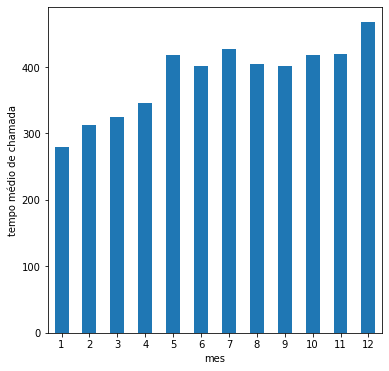

In [39]:
# Compare a duração média das ligações de cada plano para cada mês distinto. Faça um gráfico de barras para visualizá-lo.
df_surf= dft[dft['plan']== 'surf']
df_surf_mean= df_surf.groupby('month')['total_minutes'].mean()


df_surf_mean.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('tempo médio de chamada')
plt.show()


**Plano Ultimate**

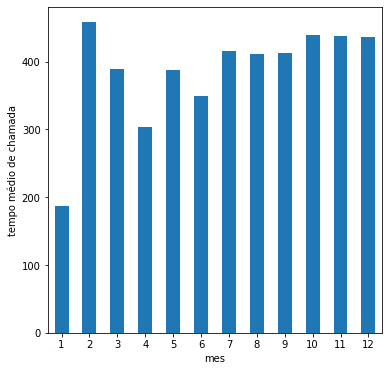

In [40]:
df_ultimate= dft[dft['plan']== 'ultimate']
df_ultimate_mean= df_ultimate.groupby('month')['total_minutes'].mean()

df_ultimate_mean.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('tempo médio de chamada')
plt.show()

* No plano Surf, durante os quatro primeiros meses, a média de tempo de chamada é inferior a 400, a partir do quinto mês, ela sobe para acima de 400. No plano Ultimate, no início do ano, a duração média das ligações fica abaixo de 200, e nos meses 4 e 6 fica abaixo de 400, enquanto nos outros meses fica sempre acima de 400. É interessante notar que o plano Surf tem um crescimento quase que sequencial, enquanto o plano Ultimate tem um crescimento desigual.

**Plano Surf**

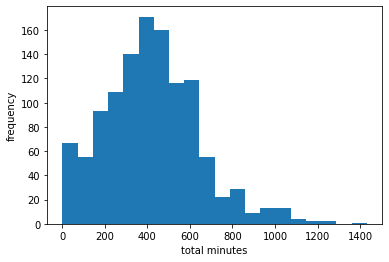

In [41]:
# Compare o número de minutos que os usuários de cada plano requerem a cada mês. Construa um histograma.
plt.hist(df_surf['total_minutes'], bins=20)
plt.xlabel('total minutes')
plt.ylabel('frequency')
plt.show()


**Plano Ultimate**

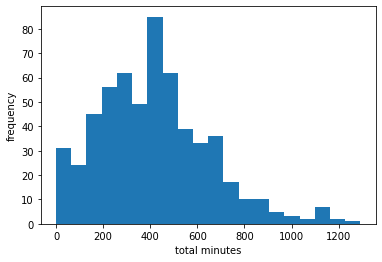

In [42]:
plt.hist(df_ultimate['total_minutes'], bins=20)
plt.xlabel('total minutes')
plt.ylabel('frequency')
plt.show()

**Plano Surf**

In [43]:
# Calcule a média e a variação da duração mensal das chamadas
df_surf['total_minutes'].mean()


420.77848305084746

In [44]:
variaçao= np.var(df_surf['total_minutes'])
variaçao

49450.61976252937

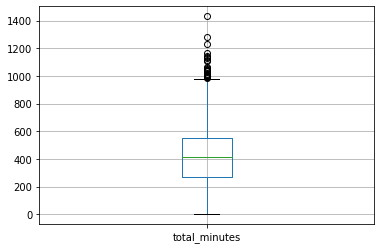

In [45]:
# Faça um diagrama de caixa para visualizar a distribuição da duração mensal das chamadas
df_surf.boxplot(column= 'total_minutes');

**Plano Ultimate**

In [46]:
df_ultimate['total_minutes'].mean()

417.5621588946459

In [47]:
variaçao= np.var(df_ultimate['total_minutes'])
variaçao


55511.1930183098

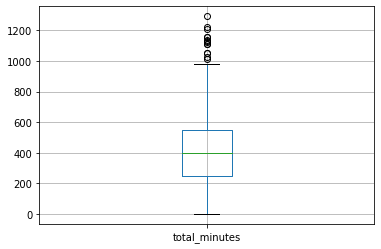

In [48]:
df_ultimate.boxplot(column= 'total_minutes');


* Perto da minutagem 400 e 600 a frequência do plano ultimate cai em relação a do plano surf, isso resulta numa media levemente maior, porém o comportamento dos dois gráficos dos dois planos são muito semelhantes apesar disso.

* Observa-se que é mais comum para os usuários do pacote Surf excederem a média de 1000 minutos, valor que já supera significativamente o limite oferecido pelo plano. Em outras palavras, neste pacote é provável que os clientes precisem pagar uma taxa extra pelo tempo excedido, enquanto que no pacote Ultimate isso não ocorre, uma vez que é oferecido um limite de 3000 minutos mensais e é perceptível que os usuários não chegam a utilizar todo esse tempo, evitando assim gastos adicionais.

### Mensagens

**Plano Surf**

In [49]:
# Compare o número de mensagens que os usuários de cada plano tendem a enviar a cada mês
df_m_surf= df_surf.groupby('month')['id_messages_count'].mean()
df_m_surf

month
1     21.000000
2     21.600000
3     21.937500
4     24.685714
5     33.547170
6     32.742857
7     34.786517
8     37.302521
9     38.585034
10    41.475138
11    40.087156
12    47.686992
Name: id_messages_count, dtype: float64

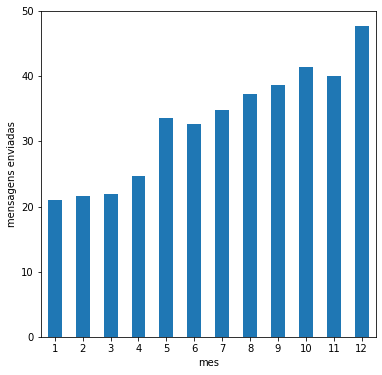

In [50]:
# Compare a quantidade de tráfego de internet consumido pelos usuários por plano
df_m_surf.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('mensagens enviadas')
plt.show()

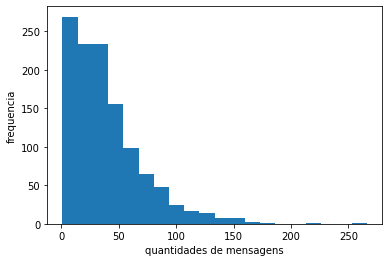

In [51]:
plt.hist(df_surf['id_messages_count'], bins=20)
plt.xlabel('quantidades de mensagens')
plt.ylabel('frequencia')
plt.show()

In [52]:
df_surf['id_messages_count'].mean()

39.489830508474576

In [53]:
variaçao= np.var(df_surf['id_messages_count'])
variaçao

1043.3329474288998

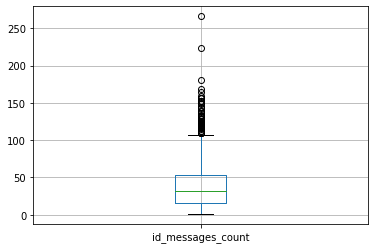

In [54]:
df_surf.boxplot(column= 'id_messages_count');

**Plano Ultimate**

In [55]:
df_m_ultimate= df_ultimate.groupby('month')['id_messages_count'].mean()
df_m_ultimate

month
1     20.666667
2     27.800000
3     34.714286
4     28.937500
5     44.333333
6     37.135135
7     41.212766
8     47.929825
9     45.901408
10    47.488636
11    47.656863
12    53.744000
Name: id_messages_count, dtype: float64

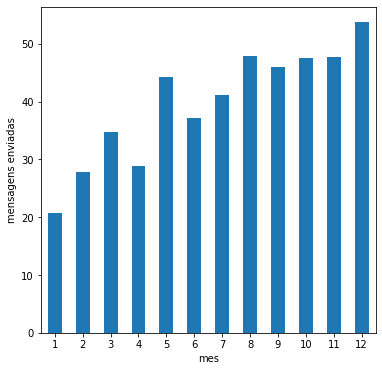

In [56]:
df_m_ultimate.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('mensagens enviadas')
plt.show()

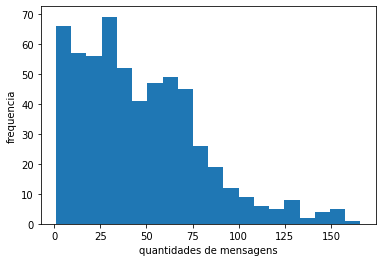

In [57]:
plt.hist(df_ultimate['id_messages_count'], bins=20)
plt.xlabel('quantidades de mensagens')
plt.ylabel('frequencia')
plt.show()

In [58]:
df_ultimate['id_messages_count'].mean()

46.4559585492228

In [59]:
variançao= np.var(df_ultimate['id_messages_count'])
variançao

1082.5209446338606

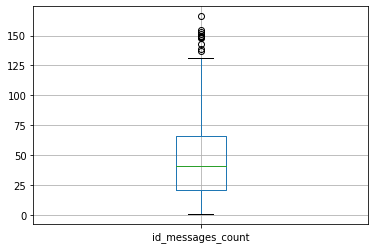

In [60]:
df_ultimate.boxplot(column= 'id_messages_count');


* A conduta delas varia conforme os planos, sendo notável uma distribuição mais equilibrada no Ultimate em comparação ao Surf. Levando em conta que o Surf permite apenas 50 mensagens mensais, é evidente que diversos usuários excedem esse limite.

### Internet

**Plano Surf**

In [61]:
df_i_surf= df_surf.groupby('month')['mb_used'].mean()
df_i_surf

month
1      7894.790000
2      9310.764000
3     12397.342500
4     11851.091429
5     14851.419623
6     15565.743286
7     16708.588315
8     17161.736891
9     16492.743197
10    17406.222376
11    16300.159358
12    17968.352602
Name: mb_used, dtype: float64

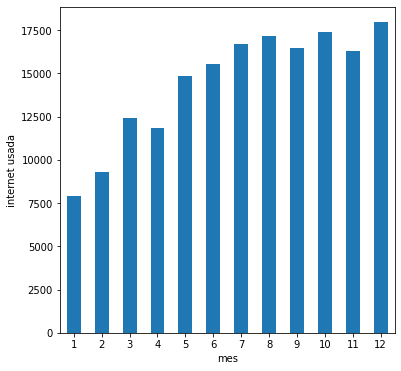

In [62]:
df_i_surf.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('internet usada')
plt.show()

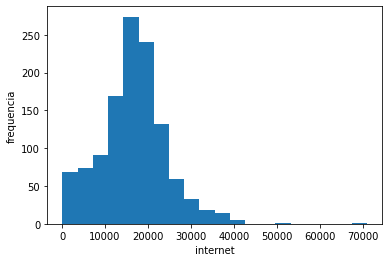

In [63]:
plt.hist(df_surf['mb_used'], bins=20)
plt.xlabel('internet')
plt.ylabel('frequencia')
plt.show()

In [64]:
df_surf['mb_used'].mean()

16629.01829661017

In [65]:
variaçao= np.var(df_surf['mb_used'])
variaçao

59459709.008884974

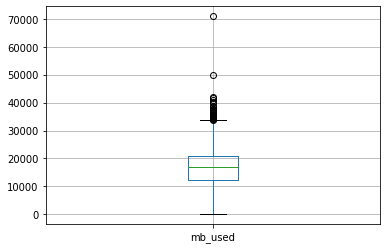

In [66]:
df_surf.boxplot(column= 'mb_used');

**Plano Ultimate**

In [67]:
df_i_ultimate= df_ultimate.groupby('month')['mb_used'].mean()
df_i_ultimate

month
1      6953.200000
2     17335.756000
3     23835.722857
4     14285.791875
5     16993.530000
6     15451.022162
7     16499.324255
8     17976.983333
9     16410.551549
10    17512.219205
11    17323.745686
12    18267.285840
Name: mb_used, dtype: float64

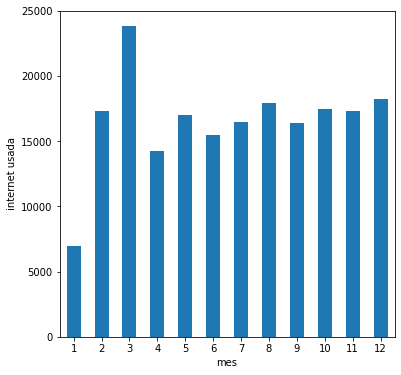

In [68]:
df_i_ultimate.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('internet usada')
plt.show()

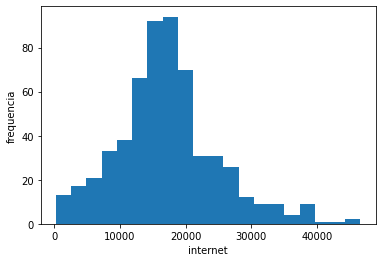

In [69]:
plt.hist(df_ultimate['mb_used'], bins=20)
plt.xlabel('internet')
plt.ylabel('frequencia')
plt.show()

In [70]:
df_ultimate['mb_used'].mean()

17250.995837651124

In [71]:
variaçao= np.var(df_ultimate['mb_used'])
variaçao

58988421.28628612

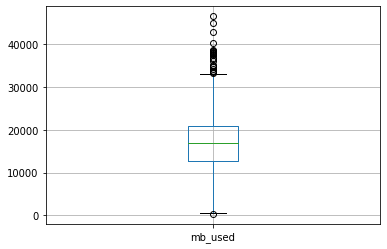

In [72]:
df_ultimate.boxplot(column= 'mb_used');



* A conduta dos planos é de certa forma semelhante, tendo em vista que diversos usuários extrapolam o limite de dados fornecido, requerendo um pagamento adicional.

## Receita

In [73]:
dft

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan,calls_+,mensagens_+,internet_+,revenue
0,1000,12,16,116.83,11,1901.47,ultimate,0.0,0.0,0.00,70.00
1,1001,8,27,171.14,30,6919.15,surf,0.0,0.0,0.00,20.00
2,1001,9,49,297.69,44,13314.82,surf,0.0,0.0,0.00,20.00
3,1001,10,65,374.11,53,22330.49,surf,0.0,3.0,7330.49,73324.99
4,1001,11,64,404.59,36,18504.30,surf,0.0,0.0,3504.30,35063.00
...,...,...,...,...,...,...,...,...,...,...,...
1754,1496,9,52,389.94,21,16389.27,surf,0.0,0.0,1389.27,13912.70
1755,1496,10,46,301.16,18,14287.36,surf,0.0,0.0,0.00,20.00
1756,1496,11,39,291.88,13,8547.36,surf,0.0,0.0,0.00,20.00
1757,1496,12,40,278.61,11,16438.99,surf,0.0,0.0,1438.99,14409.90


**Plano Surf**

In [74]:
df_r_surf= df_surf.groupby('month')['revenue'].mean()
df_r_surf

month
1        20.000000
2      2659.962120
3     17270.392250
4     19085.330917
5     28604.334257
6     29685.037611
7     39479.564134
8     42476.678488
9     35249.801945
10    42882.597915
11    35089.179591
12    45342.140498
Name: revenue, dtype: float64

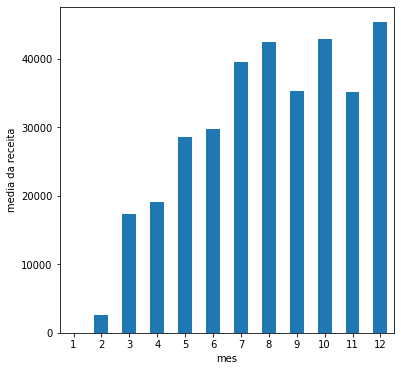

In [75]:
df_r_surf.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('media da receita')
plt.show()

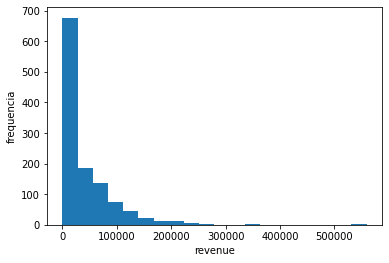

In [76]:
plt.hist(df_surf['revenue'], bins=20)
plt.xlabel('revenue')
plt.ylabel('frequencia')
plt.show()

In [77]:
df_surf['revenue'].mean()

38022.965921271185

In [78]:
variaçao= np.var(df_surf['revenue'])
variaçao

2809094926.976652

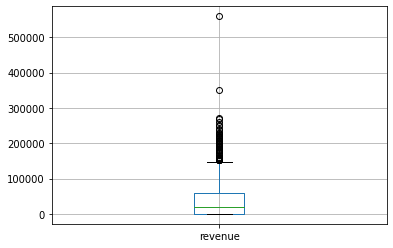

In [79]:
df_surf.boxplot(column= 'revenue');

**Plano Ultimate**

In [80]:
df_r_ultimate= df_ultimate.groupby('month')['revenue'].mean()
df_r_ultimate

month
1     70.0
2     70.0
3     70.0
4     70.0
5     70.0
6     70.0
7     70.0
8     70.0
9     70.0
10    70.0
11    70.0
12    70.0
Name: revenue, dtype: float64

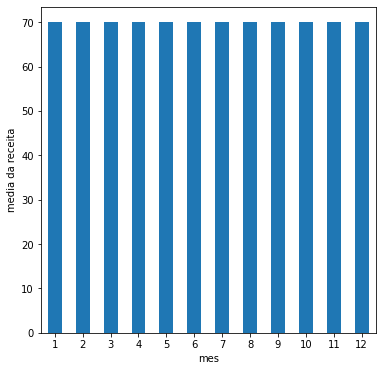

In [81]:
df_r_ultimate.plot(kind= 'bar', figsize=(6,6), rot=360)
plt.xlabel('mes')
plt.ylabel('media da receita')
plt.show()

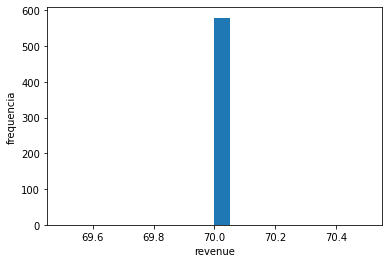

In [82]:
plt.hist(df_ultimate['revenue'], bins=20)
plt.xlabel('revenue')
plt.ylabel('frequencia')
plt.show()

In [83]:
df_ultimate['revenue'].mean()

70.0

In [84]:
variaçao= np.var(df_ultimate['revenue'])
variaçao

0.0

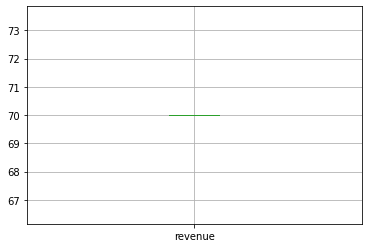

In [85]:
df_ultimate.boxplot(column= 'revenue');

* Pode-se constatar uma grande disparidade de receita entre os planos, pois os usuários do plano Surf tendem a pagar frequentemente valores excedentes à mensalidade, devido à ultrapassagem dos limites de uso. Isso acarreta um aumento considerável nos custos, o que não é observado no plano Ultimate, onde os limites são mais amplos e melhor aproveitados, mantendo os clientes dentro das margens estabelecidas e evitando cobranças extras.

## Testar hipóteses estatísticas

* Testando a hipótese de que a receita média dos usuários dos planos de chamadas Ultimate e Surf é diferente.

In [86]:
# Teste as hipóteses
#H0= receita dos planos e igual
#H1= a receita dos planos e diferente

surf_revenue= df_surf['revenue']
ultimate_revenue= df_ultimate['revenue']

alpha= 0.05

results= st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Nós rejeitamos a hipótese nula")
else:
    print("Nós não podemos rejeitar a hipótese nula")

p-value: 4.204280748985147e-108
Nós rejeitamos a hipótese nula


In [91]:
df_surf

,user_id,month,id_call_count,total_minutes,id_messages_count,mb_used,plan,calls_+,mensagens_+,internet_+,revenue
1,1001,8,27,171.14,30,6919.15,surf,0.0,0.0,0.00,20.00
2,1001,9,49,297.69,44,13314.82,surf,0.0,0.0,0.00,20.00
3,1001,10,65,374.11,53,22330.49,surf,0.0,3.0,7330.49,73324.99
4,1001,11,64,404.59,36,18504.30,surf,0.0,0.0,3504.30,35063.00
5,1001,12,56,392.93,44,19369.18,surf,0.0,0.0,4369.18,43711.80
...,...,...,...,...,...,...,...,...,...,...,...
1753,1496,8,18,114.62,2,8605.66,surf,0.0,0.0,0.00,20.00
1754,1496,9,52,389.94,21,16389.27,surf,0.0,0.0,1389.27,13912.70
1755,1496,10,46,301.16,18,14287.36,surf,0.0,0.0,0.00,20.00
1756,1496,11,39,291.88,13,8547.36,surf,0.0,0.0,0.00,20.00


* Através deste teste estatístico nós rejeitamos a hipótese nula, rejeitamos a ideia dos planos terem receitas iguais. Utilizei o teste sobre a Igualdade das Médias de Duas Populações pois era o mais correto neste caso.

* Teste a hipótese de que a receita média dos usuários da área de NY-NJ difere da dos usuários das demais regiões.

In [88]:
#H0= A receita media de NY-NJ é igual a de outras regioes
#H1= A receita media de usuários da área de NY-NJ é diferente dos usuários de outras regiões.

dfrc=dft.merge(df_users, on = 'user_id')
dfrc = dfrc[['revenue','city']]
dfnynj = dfrc.loc[dfrc['city'].str.contains('NY-NJ')]
dfnynj = dfnynj.drop('city', axis =1 ).reset_index(drop=True)
dfnynj.columns = ['revenue_NY_NJ']



dfot = dfrc.loc[~dfrc['city'].str.contains('NY-NJ')]
dfot = dfot.drop('city', axis =1 ).reset_index(drop=True)
dfot.columns = ['revenue_others']


alpha = 0.05
results2= st.ttest_ind(dfnynj,dfot, equal_var=False)
print('p-value:', results2.pvalue)

if results2.pvalue < alpha:
    print("Nós rejeitamos a hipótese nula")
else:
    print("Nós não podemos rejeitar a hipótese nula")
    
print(dfnynj.mean())

print(dfot.mean())


p-value: [0.59135563]
Nós não podemos rejeitar a hipótese nula
revenue_NY_NJ    24333.376745
dtype: float64
revenue_others    25755.822754
dtype: float64


* Através deste teste estatístico nós não rejeitamos a hipótese nula, ou seja a receita média de usuários da área de NY-NJ é diferente dos usuários de outras regiões. Utilizei o teste sobre a Igualdade das Médias de Duas Populações pois era o mais correto neste caso.

## Conclusão geral



* O plano surf por ter um limite mais baixo muitas pessoas pagam um valor extra pelo uso, superando o valor do plano ultimate muitas vezes, trazendo assim mais dinheiro para a empresa. Já o ultimate não, todos seus usuários pagam 70 dólares. Não podemos afirmar que a receita da região de NY-NJ é igual as demais, sua média é um pouco a baixo da média das demais.